In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset, DataLoader, Sampler, Dataset
from src.data_loader import *
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import os
from src.ann_model import ANN, create_dataloader, save_checkpoint, convert_tensor

In [2]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

## 1. Set up dataset and dataloader

In [2]:
f_path = 'data/selected_statslib.csv'
statslib_df = pd.read_csv(f_path)
statslib_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

f_path = 'data/selected_GBREB.csv'
GBREB_df = pd.read_csv(f_path)
GBREB_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [3]:
len(statslib_df), len(GBREB_df)

(506, 214)

In [4]:
total = pd.concat([statslib_df, GBREB_df], axis=0)
total.fillna(0, inplace=True)
# total.fillna(0, inplace=True)
total.head()

,RM,PTRATIO,LSTAT,MEDV,year,Units Sold,Active Listings,Months Supply of Inventory,New Listings,Pending Sales,Days to Off Market,Sold to Original Price Ratio,Price per Square Foot,month
0,6.575,15.3,4.98,24.0,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.421,17.8,9.14,21.6,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.185,17.8,4.03,34.7,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.998,18.7,2.94,33.4,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.147,18.7,5.33,36.2,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## list of features to feed
feature_list = list(total.columns)
feature_list.remove('MEDV')
feature_list

['RM',
 'PTRATIO',
 'LSTAT',
 'year',
 'Units Sold',
 'Active Listings',
 'Months Supply of Inventory',
 'New Listings',
 'Pending Sales',
 'Days to Off Market',
 'Sold to Original Price Ratio',
 'Price per Square Foot',
 'month']

In [6]:
gbreb_train_size = 0.4
gbreb_val_size = 0.5
gbreb_test_size = 0.5

X_gbreb_train, X_gbreb, y_gbreb_train, y_gbreb = train_test_split(total[total['year'] != 1993][feature_list], 
                                                                  total[total['year']!=1993]['MEDV'],
                                                                  train_size=gbreb_train_size, 
                                                                 shuffle=True)
X_gbreb_val, X_gbreb_test, y_gbreb_val, y_gbreb_test = train_test_split(X_gbreb, 
                                                                        y_gbreb, 
                                                                        train_size=gbreb_val_size, 
                                                                        shuffle=True)

In [7]:
X_train_set = pd.concat([total[total['year'] == 1993][feature_list], X_gbreb_train], axis=0)
y_train_set = pd.concat([total[total['year'] == 1993]['MEDV'], y_gbreb_train], axis=0)
X_val_set, y_val_set = X_gbreb_val, y_gbreb_val
X_test_set, y_test_set = X_gbreb_test, y_gbreb_test

X_train_set.reset_index(inplace=True, drop=True)
y_train_set.reset_index(inplace=True, drop=True)
X_val_set.reset_index(inplace=True, drop=True)
y_val_set.reset_index(inplace=True, drop=True)
X_test_set.reset_index(inplace=True, drop=True)
y_test_set.reset_index(inplace=True, drop=True)
y_train_set

0       24.00
1       21.60
2       34.70
3       33.40
4       36.20
        ...  
586      0.93
587    972.50
588    900.00
589    630.00
590    615.00
Name: MEDV, Length: 591, dtype: float64

In [9]:
X_train, y_train = convert_tensor(X_train_set, y_train_set)
X_val, y_val = convert_tensor(X_val_set, y_val_set)
X_test, y_test = convert_tensor(X_test_set, y_test_set)

In [10]:
X_train.shape, y_train.shape

(torch.Size([591, 13]), torch.Size([591]))

In [12]:
train_loader = create_dataloader(X_train, y_train)
valid_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test)

In [13]:
for idx, batch in enumerate(train_loader):
    print(idx, batch[0].shape, batch[1].shape)
    break

0 torch.Size([10, 13]) torch.Size([10])


In [16]:
params = {'num_layers': 20,
          'hidden_dim':13**2,
          'epoch': 1000,
          'lr': 1.5e-5,
          'loss_function':F.l1_loss}

model = ANN(input_dim=13, hidden_dim=params['hidden_dim'], output_dim=1, num_layers=params['num_layers'])
print(model)

# params = {'epoch': 100,
#          'lr': 1.5e-5,
#          'loss_function':F.mse_loss}

#'lossfunction':F.mse_loss#
optimizer = optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=169, bias=True)
    (1): ReLU()
    (2): Linear(in_features=169, out_features=169, bias=True)
    (3): ReLU()
    (4): Linear(in_features=169, out_features=169, bias=True)
    (5): ReLU()
    (6): Linear(in_features=169, out_features=169, bias=True)
    (7): ReLU()
    (8): Linear(in_features=169, out_features=169, bias=True)
    (9): ReLU()
    (10): Linear(in_features=169, out_features=169, bias=True)
    (11): ReLU()
    (12): Linear(in_features=169, out_features=169, bias=True)
    (13): ReLU()
    (14): Linear(in_features=169, out_features=169, bias=True)
    (15): ReLU()
    (16): Linear(in_features=169, out_features=169, bias=True)
    (17): ReLU()
    (18): Linear(in_features=169, out_features=169, bias=True)
    (19): ReLU()
    (20): Linear(in_features=169, out_features=169, bias=True)
    (21): ReLU()
    (22): Linear(in_features=169, out_features=169, bias

In [18]:
train_loss = []
train_val_loss = []
val_loss = []
print_step = 100

for epoch in range(params['epoch']):
    epoch += 1
    if epoch % print_step == 0:
        print(f'\n>>> Epoch {epoch} <<<')
    
    ## training
    model.train()
    running_loss, running_acc = 0, 0
    for i, data in enumerate(train_loader):
        X_data = data[0]
        y_target = data[1]
        y_pred = model(X_data).reshape(-1)

        loss = params["loss_function"](y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()        
#         if i % print_step == 0:
#             s = '%d: Train loss: %.4f'%(i, loss.item())
#             print(s)
            
    train_loss.append(running_loss / len(train_loader))
    if epoch % print_step == 0:
        print('Epoch: {}, Train loss: {:.4f}'.format(epoch, train_loss[epoch-1]))
    
    ## validation
    model.eval()
    loss_ = 0.
    for i, data in enumerate(valid_loader):
        X, y_true = data[0], data[1]
        y = model(X).reshape(-1)
        loss += params["loss_function"](y_true, y)
    
    val_loss.append(loss.item() / len(valid_loader))
    if epoch % print_step == 0:
        print('Epoch: {}, Validation loss: {:.4f}'.format(epoch, val_loss[epoch-1]))
    
    ## save the model
    if epoch % print_step == 0:
        prefix = 'ann_' + str(params['num_layers']) + '_' + str(epoch)
        save_checkpoint(model, epoch, train_loss, val_loss, prefix=prefix)


>>> Epoch 100 <<<
Epoch: 100, Train loss: 105.5550
Epoch: 100, Validation loss: 607.2222
model checkpoint saved @ ./saves/ann_20_100.pth

>>> Epoch 200 <<<
Epoch: 200, Train loss: 43.4474
Epoch: 200, Validation loss: 216.1523
model checkpoint saved @ ./saves/ann_20_200.pth

>>> Epoch 300 <<<
Epoch: 300, Train loss: 52.6704
Epoch: 300, Validation loss: 292.0015
model checkpoint saved @ ./saves/ann_20_300.pth

>>> Epoch 400 <<<
Epoch: 400, Train loss: 37.9470
Epoch: 400, Validation loss: 261.1713
model checkpoint saved @ ./saves/ann_20_400.pth

>>> Epoch 500 <<<
Epoch: 500, Train loss: 37.1039
Epoch: 500, Validation loss: 239.9618
model checkpoint saved @ ./saves/ann_20_500.pth

>>> Epoch 600 <<<
Epoch: 600, Train loss: 25.0113
Epoch: 600, Validation loss: 147.1919
model checkpoint saved @ ./saves/ann_20_600.pth

>>> Epoch 700 <<<
Epoch: 700, Train loss: 31.8694
Epoch: 700, Validation loss: 239.9981
model checkpoint saved @ ./saves/ann_20_700.pth

>>> Epoch 800 <<<
Epoch: 800, Train los

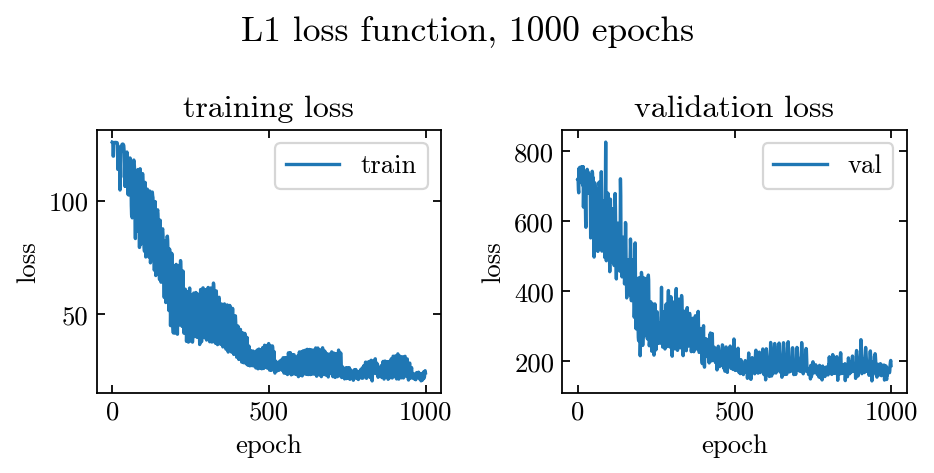

In [21]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'training loss')
plt.legend()
          
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation loss')
plt.legend()
          
plt.suptitle('L1 loss function, {} epochs'.format(params['epoch']), fontsize=16)
plt.tight_layout()
plt.savefig('figure/ann_loss_plot.pdf', dpi=300)
plt.show()

## Model Evaluation

In [15]:
test_loader = create_dataloader(X_test, y_test, batch_size=1)

In [16]:
params = {'num_layers': 20,
          'hidden_dim':13**2,
          'epoch': 1000,
          'lr': 1.5e-5,
          'loss_function':F.l1_loss}

model = ANN(input_dim=13, hidden_dim=params['hidden_dim'], output_dim=1, num_layers=params['num_layers'])
PATH = './saves/ann_20_1000.pth'
saved_model = torch.load(PATH)
model.load_state_dict(saved_model['model'])

<All keys matched successfully>

In [17]:
with torch.no_grad():
    model.eval()
    y_pred = []
    y_true = []
    year = []
    for i, batch in enumerate(test_loader):
        output = model(batch[0]).reshape(-1)
        y_pred.append(output.detach().numpy())
        y_true.append(batch[1].detach().numpy())
        year.append(np.array(batch[0][:, 3]))
    

In [18]:
year = np.array(year)
np.unique(year)

array([2017., 2018., 2019., 2020., 2021., 2022.], dtype=float32)

In [19]:
obj = {}
for y in np.unique(year):
    y = int(y)
    s = 'medv_' + str(y)
    obj[s] = []
obj

{'medv_2017': [],
 'medv_2018': [],
 'medv_2019': [],
 'medv_2020': [],
 'medv_2021': [],
 'medv_2022': []}

In [20]:
for i in range(len(year)):
    if year[i] == 2017:
        obj['medv_'+ str(int(year[i]))].append((y_pred[i], y_true[i]))
    elif year[i] == 2018:
        obj['medv_'+ str(int(year[i]))].append([y_pred[i], y_true[i]])
    elif year[i] == 2019:
        obj['medv_'+ str(int(year[i]))].append([y_pred[i], y_true[i]])
    elif year[i] == 2020:
        obj['medv_'+ str(int(year[i]))].append([y_pred[i], y_true[i]])
    elif year[i] == 2021:
        obj['medv_'+ str(int(year[i]))].append([y_pred[i], y_true[i]])
    elif year[i] == 2022:
        obj['medv_'+ str(int(year[i]))].append([y_pred[i], y_true[i]])

In [21]:
for dic in list(obj.keys()):
    obj[dic] = np.array(obj[dic]).reshape(-1, 2)

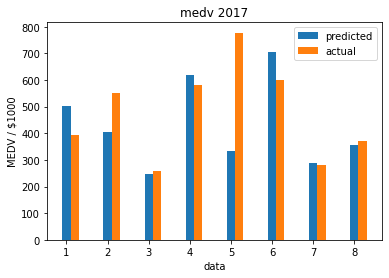

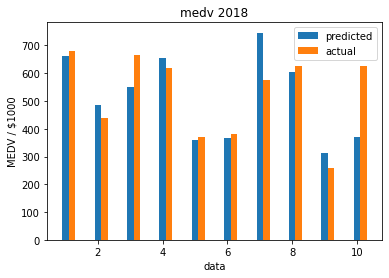

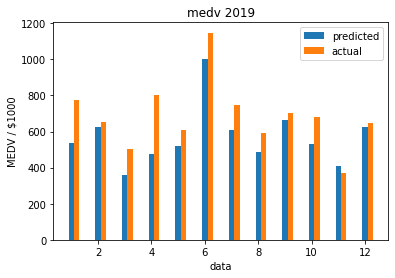

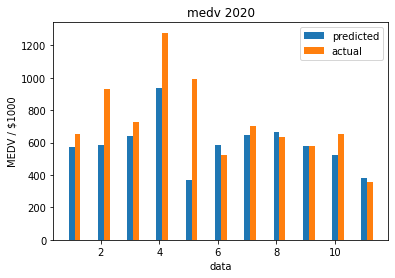

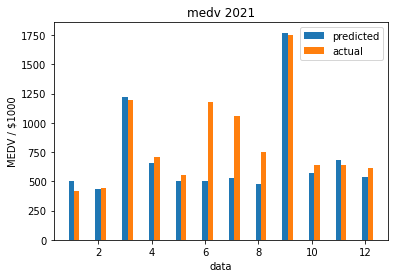

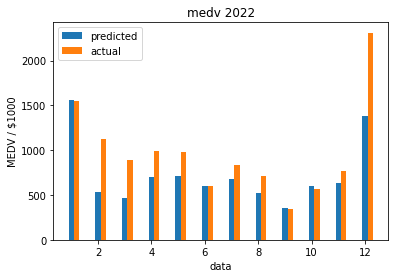

In [22]:
for dic in list(obj.keys()):
    width = 0.4
    x_dummy = np.linspace(1, len(obj[dic][:, 0]), len(obj[dic][:, 0]))

    plt.bar(x_dummy, obj[dic][:, 0], width/2, label='predicted')
    plt.bar(x_dummy+0.2, obj[dic][:, 1], width/2, label='actual')
    plt.legend()
    plt.xlabel('data')
    plt.ylabel('MEDV / $1000')
    plt.title(dic.replace('_', ' '))
    plt.show()

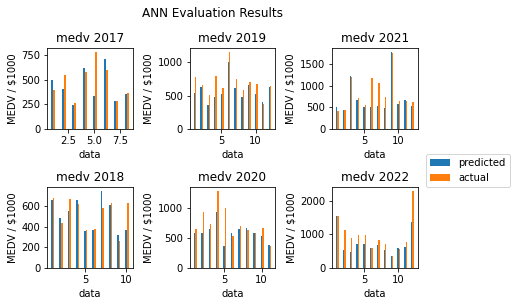

In [53]:
fig, axs = plt.subplots(2, 3)
m, n, l = 0, 0, 0

for i in range(len(list(obj.keys()))):
    x_dummy = np.linspace(1, len(obj[list(obj.keys())[i]][:, 0]), len(obj[list(obj.keys())[i]][:, 0]))
    if i % 2 == 0:
        axs[0, m].bar(x_dummy, obj[list(obj.keys())[i]][:, 0], width/2, label='predicted') 
        axs[0, m].bar(x_dummy+width/2, obj[list(obj.keys())[i]][:, 1], width/2, label='actual')
        axs[0, m].set_title(list(obj.keys())[i].replace('_', ' '))
    
        m += 1
        
    elif i % 2 == 1:
        axs[1, n].bar(x_dummy, obj[list(obj.keys())[i]][:, 0], width/2, label='predicted') 
        axs[1, n].bar(x_dummy+width/2, obj[list(obj.keys())[i]][:, 1], width/2, label='actual')
        axs[1, n].set_title(list(obj.keys())[i].replace('_', ' '))
        n += 1
            
for ax in axs.flat:
    ax.set(xlabel='data', ylabel='MEDV / $1000')

fig.tight_layout()
plt.legend(loc=(1.1, 1))
fig.suptitle('ANN Evaluation Results', y=1.05)
fig.savefig('./figure/medv_ann_bar.pdf', dpi=300, bbox_inches='tight')